In [2]:
import warnings
import joblib
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz,export_text
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV,cross_validate, validation_curve
from skompiler import skompile

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore", category=Warning)

In [3]:
df=pd.read_csv(r"C:/Users/azizd/Desktop/Miull/Machine Learning/machine_learning-220803-231749/machine_learning/datasets/diabetes.csv")

y=df.Outcome

X=df.drop(columns=['Outcome'],axis=1)

In [4]:
cart_model= DecisionTreeClassifier(random_state=1).fit(X,y)

y_pred=cart_model.predict(X)

y_prob=cart_model.predict_proba(X)[:,1]

print(classification_report(y,y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       268

    accuracy                           1.00       768
   macro avg       1.00      1.00      1.00       768
weighted avg       1.00      1.00      1.00       768



In [5]:
roc_auc_score(y,y_prob)

1.0

In [6]:
# Holdout validation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

cart_model= DecisionTreeClassifier(random_state=17).fit(X_train,y_train)

y_pred=cart_model.predict(X_train)

y_prob=cart_model.predict_proba(X_train)[:,1]

print(classification_report(y_train,y_pred))

roc_auc_score(y_train,y_prob)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       350
           1       1.00      1.00      1.00       187

    accuracy                           1.00       537
   macro avg       1.00      1.00      1.00       537
weighted avg       1.00      1.00      1.00       537



1.0

In [7]:
y_pred=cart_model.predict(X_test)

y_prob=cart_model.predict_proba(X_test)[:,1]

print(classification_report(y_test,y_pred))

roc_auc_score(y_test,y_prob)

              precision    recall  f1-score   support

           0       0.77      0.78      0.77       150
           1       0.58      0.57      0.57        81

    accuracy                           0.71       231
   macro avg       0.68      0.67      0.67       231
weighted avg       0.70      0.71      0.70       231



0.6739506172839506

In [ ]:
# Cross Validation

cart_model= DecisionTreeClassifier(random_state=17).fit(X,y)

cv_results=cross_validate(cart_model,X,y,cv=5,scoring=['accuracy',"f1",'roc_auc'])

print(cv_results['test_accuracy'].mean())
print(cv_results['test_f1'].mean())	
print(cv_results['test_roc_auc'].mean())


0.7058568882098294
0.5710621194523633
0.6719440950384347


In [18]:
cart_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 17,
 'splitter': 'best'}

In [33]:
# Hiperparameter Optimization

cart_params={'max_depth':range(1,11),
			"min_samples_split":range(2,20)}

cart_best_model=GridSearchCV(cart_model,
							 cart_params,
							 cv=5,
							 n_jobs=-1,
							 verbose=1).fit(X_train,y_train)

cart_best_model.best_params_

Fitting 5 folds for each of 180 candidates, totalling 900 fits


{'max_depth': 6, 'min_samples_split': 19}

In [34]:
cart_best_model.best_score_

0.754257528556594

In [37]:
random=X.sample(1,random_state=45)

cart_best_model.predict(random)

array([1], dtype=int64)

In [38]:
cart_final= DecisionTreeClassifier(**cart_best_model.best_params_,random_state=17).fit(X,y)

cart_final.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 19,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 17,
 'splitter': 'best'}

In [39]:
cart_final= cart_model.set_params(**cart_best_model.best_params_).fit(X,y)

cross_validate_results= cross_validate(cart_final,X,y,cv=5,scoring=['accuracy',"f1",'roc_auc'])

print(cross_validate_results['test_accuracy'].mean())
print(cross_validate_results['test_f1'].mean())
print(cross_validate_results['test_roc_auc'].mean())

0.7188014599779307
0.5902897708876248
0.7830457721872817


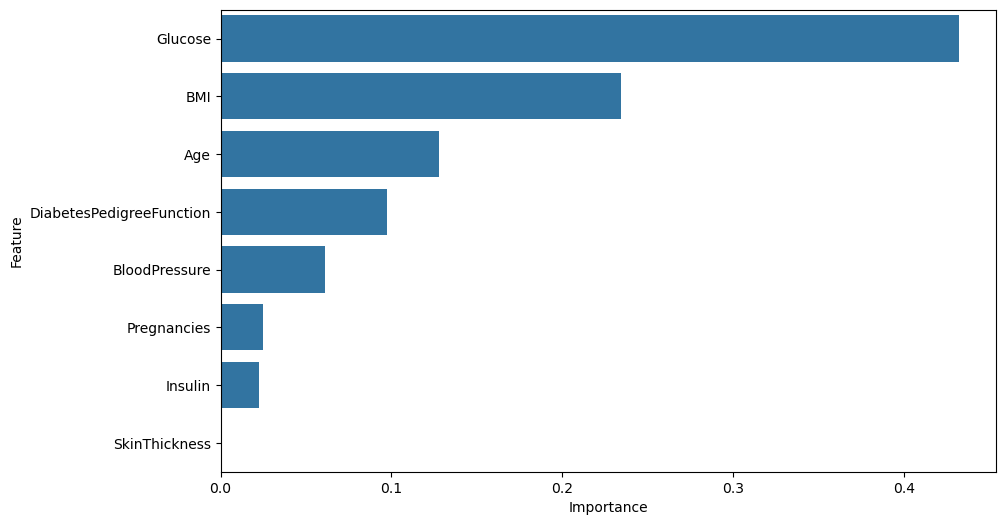

In [40]:
# Feature Importance

feature_importance=cart_final.feature_importances_
feature_importance_df=pd.DataFrame({"Feature":X.columns,"Importance":feature_importance}).sort_values(by="Importance",ascending=False)

feature_importance_df.to_csv("feature_importance.csv",index=False)
plt.figure(figsize=(10,6))
sns.barplot(x="Importance",y="Feature",data=feature_importance_df)
plt.show()

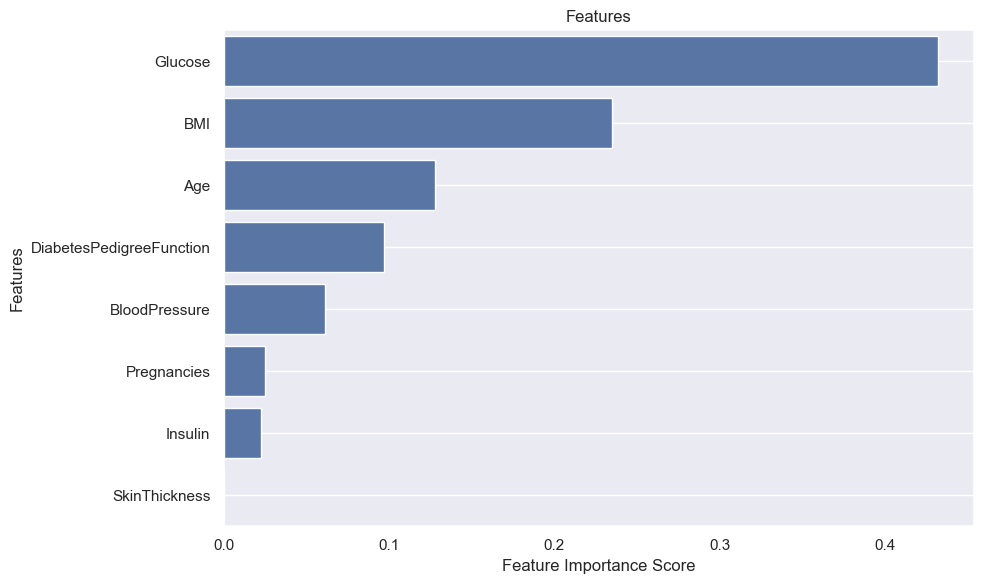

In [46]:
def plot_importance(model,features,num=len(X),save=False):

	feature_imp= pd.DataFrame({"Value":model.feature_importances_,"Feature":features.columns})
	plt.figure(figsize=(10,6))
	sns.set(font_scale=1)
	sns.barplot(x="Value",y="Feature",data=feature_imp.sort_values(by="Value",ascending=False)[0:num])

	plt.title('Features')
	plt.tight_layout()
	plt.ylabel('Features')
	plt.xlabel('Feature Importance Score')
	plt.grid()
	plt.show()
	if save:
		plt.savefig("feature_importance.png")
	

plot_importance(cart_final,X)


In [49]:
# Analyzing Model Complexity With Learning Curves

train_score, test_score=validation_curve(cart_final,X,y,
										 param_name="max_depth",
										 param_range=range(1,11),
										 scoring="roc_auc",
										 cv=10)
test_score

array([[0.64777778, 0.64925926, 0.68074074, 0.64481481, 0.64222222,
        0.68481481, 0.63666667, 0.75333333, 0.71692308, 0.75615385],
       [0.73407407, 0.74888889, 0.73555556, 0.71592593, 0.61703704,
        0.77777778, 0.70481481, 0.82555556, 0.74615385, 0.80038462],
       [0.78407407, 0.81333333, 0.77222222, 0.68296296, 0.69296296,
        0.82925926, 0.79259259, 0.85814815, 0.72615385, 0.80807692],
       [0.76481481, 0.81148148, 0.74962963, 0.60740741, 0.74296296,
        0.82111111, 0.83703704, 0.87333333, 0.75884615, 0.81961538],
       [0.7262963 , 0.78740741, 0.77925926, 0.5962963 , 0.74703704,
        0.84740741, 0.79777778, 0.88296296, 0.77730769, 0.80923077],
       [0.75185185, 0.75851852, 0.75333333, 0.60814815, 0.77592593,
        0.82555556, 0.85037037, 0.83185185, 0.76538462, 0.77615385],
       [0.73740741, 0.7537037 , 0.77703704, 0.62962963, 0.73814815,
        0.8137037 , 0.85703704, 0.85703704, 0.76538462, 0.78884615],
       [0.73111111, 0.74259259, 0.7796296

In [50]:
mean_test_score= np.mean(test_score,axis=1)
mean_train_score= np.mean(train_score,axis=1)

mean_test_score,mean_train_score

(array([0.68127066, 0.74061681, 0.77597863, 0.77862393, 0.77509829,
        0.7697094 , 0.77179345, 0.75396866, 0.74506838, 0.74446011]),
 array([0.70729413, 0.78976751, 0.83642714, 0.87308045, 0.90118357,
        0.92371345, 0.9409697 , 0.94985091, 0.95598574, 0.96021198]))

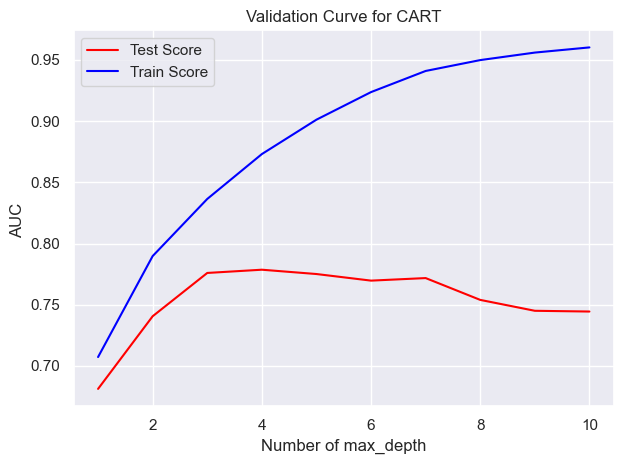

In [51]:
plt.plot(range(1,11),mean_test_score,label="Test Score",color="red")
plt.plot(range(1,11),mean_train_score,label="Train Score",color="blue")
plt.title("Validation Curve for CART")
plt.xlabel("Number of max_depth")
plt.ylabel("AUC ")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

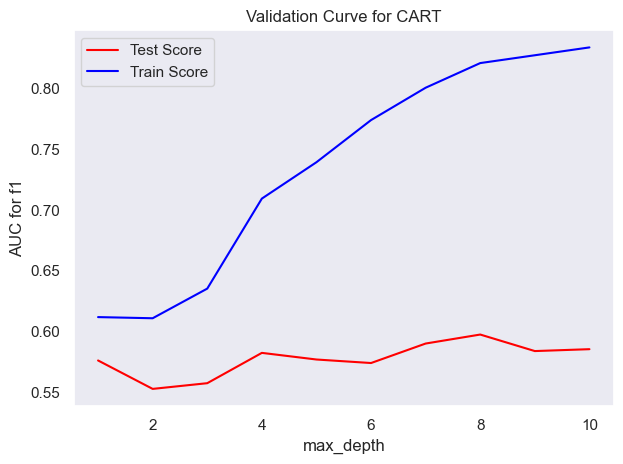

In [64]:
def val_curve_params(model,X,y,param_name,param_range,scoring="roc_auc",cv=10):
	train_score, test_score=validation_curve(model,X,y,
											 param_name=param_name,
											 param_range=param_range,
											 scoring=scoring,
											 cv=cv)
	mean_test_score= np.mean(test_score,axis=1)
	mean_train_score= np.mean(train_score,axis=1)

	plt.plot(param_range,mean_test_score,label="Test Score",color="red")
	plt.plot(param_range,mean_train_score,label="Train Score",color="blue")
	plt.title("Validation Curve for CART")
	plt.xlabel(param_name)
	plt.ylabel(f"AUC for {scoring}")
	plt.grid()
	plt.tight_layout()
	plt.legend(loc="best")
	plt.show()
val_curve_params(cart_final,X,y,"max_depth",range(1,11),scoring="f1")

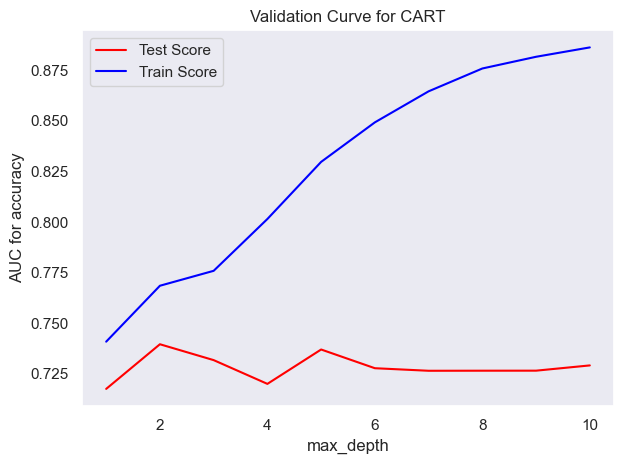

In [59]:
val_curve_params(cart_final,X,y,"max_depth",range(1,11),scoring="accuracy")

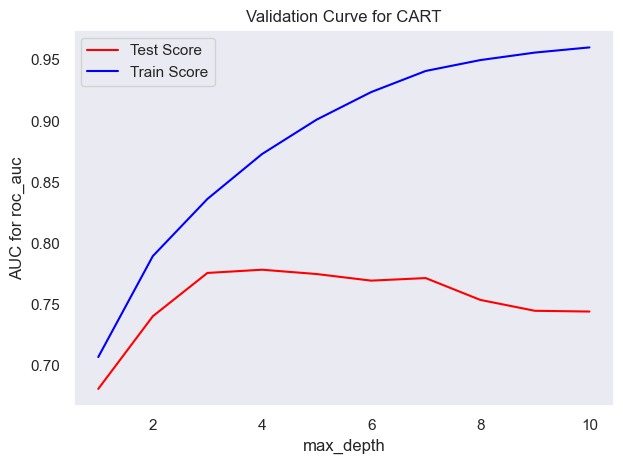

In [60]:
val_curve_params(cart_final,X,y,"max_depth",range(1,11),scoring="roc_auc")

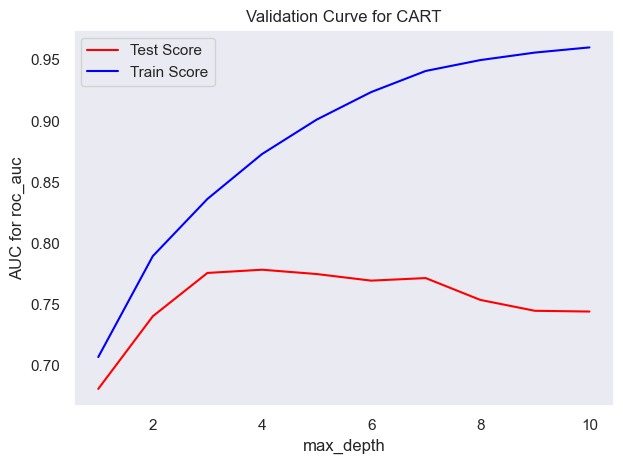

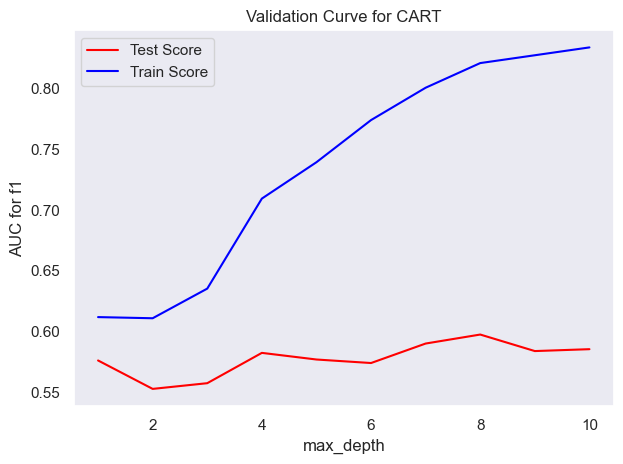

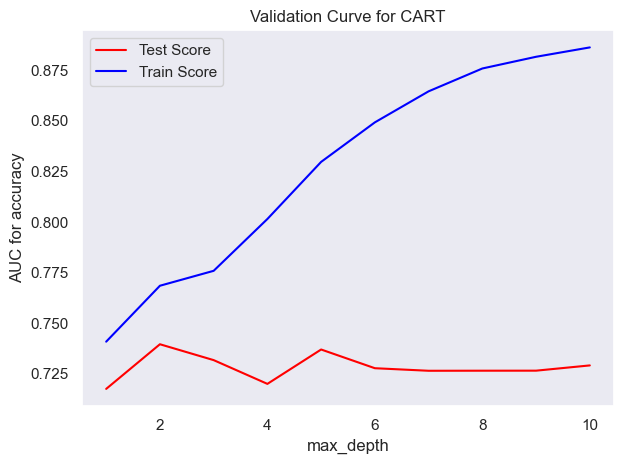

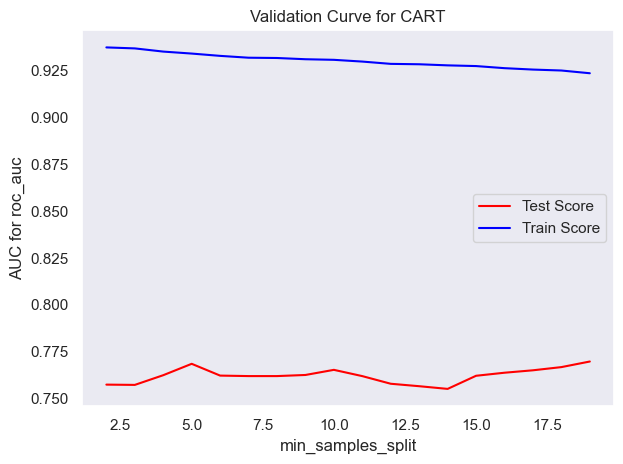

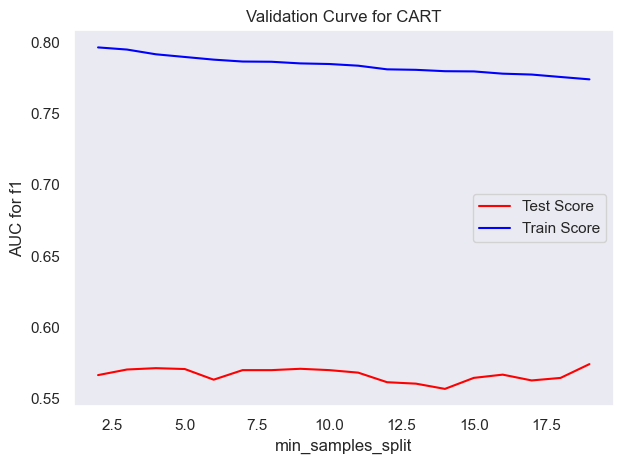

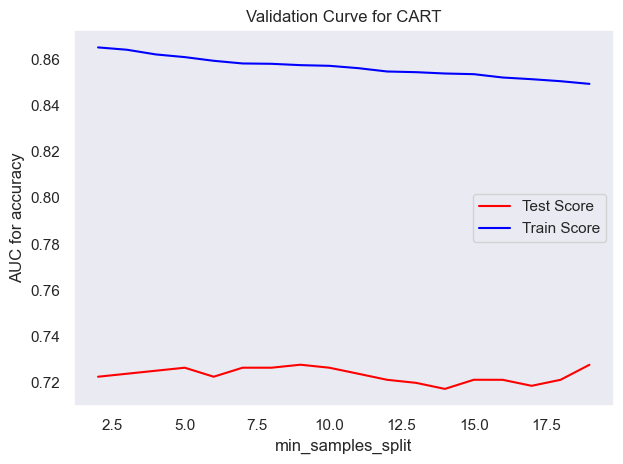

In [65]:
cart_val_params=[["max_depth",range(1,11)],
				["min_samples_split",range(2,20)]]


for i in range(len(cart_val_params)):
	val_curve_params(cart_final,X,y,cart_val_params[i][0],cart_val_params[i][1],scoring="roc_auc")
	val_curve_params(cart_final,X,y,cart_val_params[i][0],cart_val_params[i][1],scoring="f1")
	val_curve_params(cart_final,X,y,cart_val_params[i][0],cart_val_params[i][1],scoring="accuracy")

In [76]:
pip install graphviz pydotplus --upgrade

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#Visualization the Decision Tree

import graphviz
import pydotplus
from sklearn.tree import export_graphviz

def tree_graph(model, col_names, file_names):
	tree_str= export_graphviz(model, feature_names=col_names, filled=True, out_file=None )
	graph=pydotplus.graph_from_dot_data(tree_str)
	graph.write_png(file_names)

tree_graph(model=cart_final,col_names=X.columns,file_names="cart_tree.png")

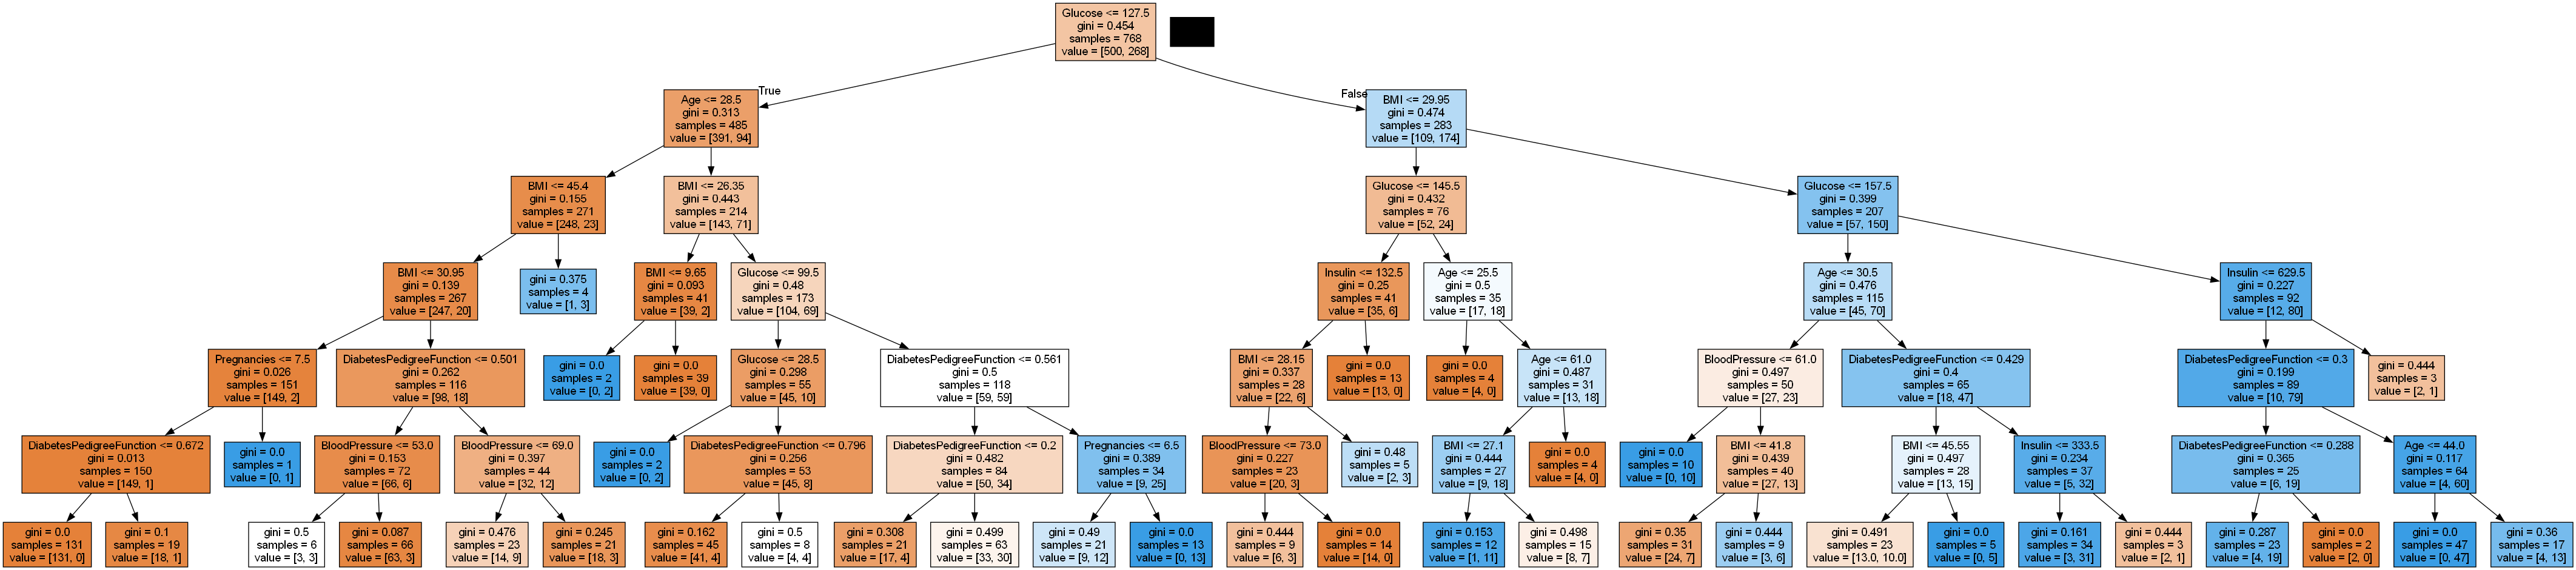

In [ ]:
from IPython.display import Image

tree_graph(model=cart_final, col_names=X.columns, file_names="cart_tree.png")

Image(filename="cart_tree.png", width=1300)  

In [100]:
cart_final.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 19,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 17,
 'splitter': 'best'}

In [101]:
# Extracting Decision Tree Rules

tree_rules=export_text(cart_final, feature_names=list(X.columns))
print(tree_rules)

|--- Glucose <= 127.50
|   |--- Age <= 28.50
|   |   |--- BMI <= 45.40
|   |   |   |--- BMI <= 30.95
|   |   |   |   |--- Pregnancies <= 7.50
|   |   |   |   |   |--- DiabetesPedigreeFunction <= 0.67
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- DiabetesPedigreeFunction >  0.67
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- Pregnancies >  7.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- BMI >  30.95
|   |   |   |   |--- DiabetesPedigreeFunction <= 0.50
|   |   |   |   |   |--- BloodPressure <= 53.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- BloodPressure >  53.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- DiabetesPedigreeFunction >  0.50
|   |   |   |   |   |--- BloodPressure <= 69.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- BloodPressure >  69.00
|   |   |   |   |   |   |--- class: 0
|   |   |--- BMI >  45.40
|   |   |   |--- class: 1
|   |--- Age >  28.50
|   |   |--- BMI <= 26.35
|   |   |